In [65]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Conv2D, ConvLSTM2D, TimeDistributed
from sklearn.externals import joblib
import pylidc as pl
import pydot

from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
image_size = (256, 256)
num_slices = 50

In [62]:
model = Sequential()
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), input_shape=(num_slices, *image_size, 1),
                     padding='same', return_sequences=True))
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), input_shape=(num_slices, *image_size, 1),
                     padding='same', return_sequences=True))
model.add(ConvLSTM2D(filters=20, kernel_size=(3, 3), input_shape=(num_slices, *image_size, 1),
                     padding='same', return_sequences=True))
model.add(TimeDistributed(Conv2D(1, 1, activation='sigmoid')))
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
#from keras.utils import plot_model
#plot_model(model, to_file='lstm_model.png')

In [44]:
unet = load_model('unet.hdf5')
lstm = load_model('unet_lstm.hdf5')

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_15 (ConvLSTM2D) (None, 50, 256, 256, 20)  15200     
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (None, 50, 256, 256, 20)  28880     
_________________________________________________________________
conv_lst_m2d_17 (ConvLSTM2D) (None, 50, 256, 256, 20)  28880     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 50, 256, 256, 1)   21        
Total params: 72,981
Trainable params: 72,981
Non-trainable params: 0
_________________________________________________________________


In [45]:
scans = pl.query(pl.Scan)
n = scans.count()

In [46]:
test = joblib.load('test_set.p')
train = list(set(range(n)) - set(test))

In [60]:
def get_data(i, only_nodules=True):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    y = np.expand_dims(y, axis=-1)
    start = np.random.randint(n - num_slices)
    X = X[start:start + num_slices]
    y = y[start:start + num_slices]
    #y = np.expand_dims(y, axis=-1)
    return unet.predict(X, batch_size=1)[None], y[None]

In [48]:
num_epochs = 2
num_samples = 200

In [68]:
for _ in range(num_samples):
    while True:
        i = np.random.choice(train)
        print(i)
        try:
            X, y = get_data(i)
            model.fit(X, y, batch_size=1, epochs=num_epochs)
            model.save('unet_lstm_new.hdf5')
            break
        except OSError:
            print('Problem getting data')

814
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0242 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0240 - acc: 1.0000
697
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0239 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0237 - acc: 1.0000
255
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0235 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0233 - acc: 1.0000
214
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0230 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0228 - acc: 1.0000
894
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0227 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0225 - acc: 1.0000
922
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0224 - acc: 1.00

1/1 [==============================] - 5s 5s/step - loss: 0.0123 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0122 - acc: 1.0000
399
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0123 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0122 - acc: 1.0000
805
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0122 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0121 - acc: 1.0000
336
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0119 - acc: 1.0000
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0118 - acc: 1.0000
406
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0126 - acc: 0.9998
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.0125 - acc: 0.9998
218
Epoch 1/2
1/1 [==============================] - 5s 5s/step - loss: 0.0115 - acc: 1.0000
Epoch 2/2
1

KeyboardInterrupt: 

In [ ]:
#model.save('unet_lstm.hdf5')

In [70]:
# evaluate lstm vs unet
ind = np.random.choice(test)
X, y = get_data(ind)
preds_unet = X
fpr_unet, tpr_unet, _ = roc_curve(np.rint(y).flatten(), preds_unet.flatten())

preds_lstm = model.predict(preds_unet, batch_size=1)
fpr_lstm, tpr_lstm, _ = roc_curve(np.rint(y).flatten(), preds_lstm.flatten())

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [21]:
# X_unet = X.reshape((-1, *image_size, 1))
# y_unet = y.reshape((-1, *image_size, 1))

In [71]:
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_unet, tpr_unet))

nan
nan


In [75]:
tpr_unet

array([nan, nan, nan, ..., nan, nan, nan])

In [76]:
np.rint(y).flatten()

array([0., 0., 0., ..., 0., 0., 0.])

In [77]:
preds_lstm.flatten()

array([0.40970114, 0.37121758, 0.36049712, ..., 0.00108374, 0.00108374,
       0.00111505], dtype=float32)

In [23]:
print(auc(fpr_lstm, tpr_lstm))
print(auc(fpr_unet, tpr_unet))

0.9732168007531221
0.7169184511734369


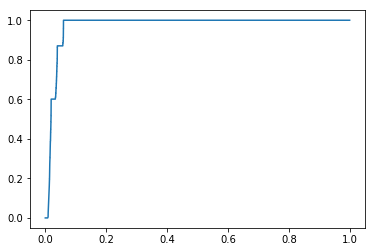

In [17]:
plt.plot(fpr, tpr)

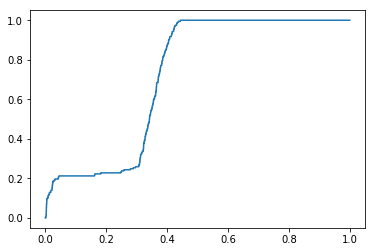

In [24]:
plt.plot(fpr_unet, tpr_unet)